# **Analiza sentymentu użytkowników nitki r/VaccineMyths**
---



---



## **1. Cel i założenia projektu**

W niniejszym projekcie przeprowadzam analizę sentymentu użytkowników Reddita w temacie szczepień. Dane pochodzą ze strony [kaggle](https://www.kaggle.com/gpreda/reddit-vaccine-myths). Zostały zebrane z nitki r/VaccineMyths i zawierają 1538 rekordów.

Analiza sentymentu jest rodzajem analizy semantycznej należącej do szerszej grupy algorytmów Natural Language Processing (w skrócie NLP). Zajmuje się analizowaniem emocjonalnego kontekstu tekstów i, co za tym idzie, stanu autora w momencie pisania. Opiera się na wychwytywaniu słów oraz zbiorów słów o wyraźnie pozytywnej lub negatywnej konotacji.

W swojej pracy postanowiłem sprawdzić czy sentyment użytkowników reddita do szczepień zmienił się kiedy szczepienia przeciwko COVID-19 zaczęły być tematem dyskusji w internecie i mediach.

## **2. Dane - wstępna ocena i przygotowanie**

### **2.1. Wizualizacja danych i dane brakujące**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('reddit_vm.csv')
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28



  **Kolumny:**

*   title - tytuł posta
*   score - ocena popularności bazowana na ilości komentarzy i reakcji. W przypadku komentarzy brano pod uwagę ilość reakcji oraz odpowiedzi
*   id - unikalny identyfikator
*   url - adres posta
*   commns_num - ilość komentarzy
*   created - data dodania posta
*   body - treść posta bądź komentarza
*   timestamp - data dodania posta lub komentarza


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1538 entries, 2021-02-27 06:33:45 to 2019-04-16 13:40:32
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1538 non-null   object 
 1   score      1538 non-null   int64  
 2   id         1538 non-null   object 
 3   url        455 non-null    object 
 4   comms_num  1538 non-null   int64  
 5   created    1538 non-null   float64
 6   body       1172 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 96.1+ KB


Jak widać na powyższym podsumowaniu braki w danych
znajdują się wyłącznie w kolumnach "url" oraz "body". Ta pierwsza w ogóle nie jest potrzebna do analizy sentymentu, natomiast druga może pozostać pusta tak długo jak w kolumnie "title" znajduje się tekst. W związku z tym postanowiłem nie usuwać żadnych rekordów.

### **2.2. Analiza danych pod kątem dat**

Zakres dat: 2014-01-13 16:42:55 ---------> 2021-06-22 15:24:40 



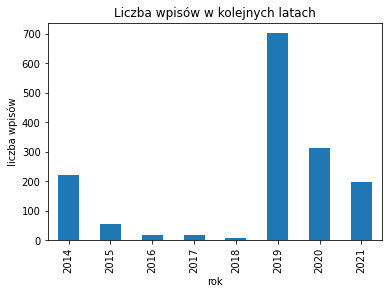

In [ ]:
print('Zakres dat:', df['timestamp'].min(), '--------->', df['timestamp'].max(), '\n')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace = True)
fig, ax = plt.subplots()
fig = df.resample('1Y').count()['id'].plot(kind="bar")
ax.set_title("Liczba wpisów w kolejnych latach")
ax.set_xlabel("rok")
ax.set_ylabel("liczba wpisów")
ax.set_xticklabels(['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'])
plt.show()

Na powyższym wykresie widać, iż nitka r/VaccineMyths znacząco straciła na popularności w latach 2015-2018. W danych znajduje się niewiele rekordów z tego okresu. Łatwo zauważyć również gwałtowny wzrost liczby rekordów w roku 2019, co pokrywa się z początkiem pandemii COVID-19.

### **2.3. Ocena popularności tematu szczepień**

W celu weryfikacji hipotezy braku wpływu szczepionek przeciwko COVID-19 na ogólne postrzeganie szczepień przez społeczność reddita użyłem strony [google trends](https://trends.google.com) do sprawdzenia popularności hasła "vaccines" w skali światowej na przestrzeni ostatnich dwóch lat. Dane wyraźnie pokazują wzrost częstotliwości wyszukiwania tej frazy od listopada 2020 roku związany z początkiem głośnego dyskursu na temat szczepień covidowych. Na tej podstawie przyjmuję datę 01.11.2020 jako umowną granicę, na podstawie której sprawdzę czy zjawisko to miało jakikolwiek wpływ na sentyment użytkowników reddita.

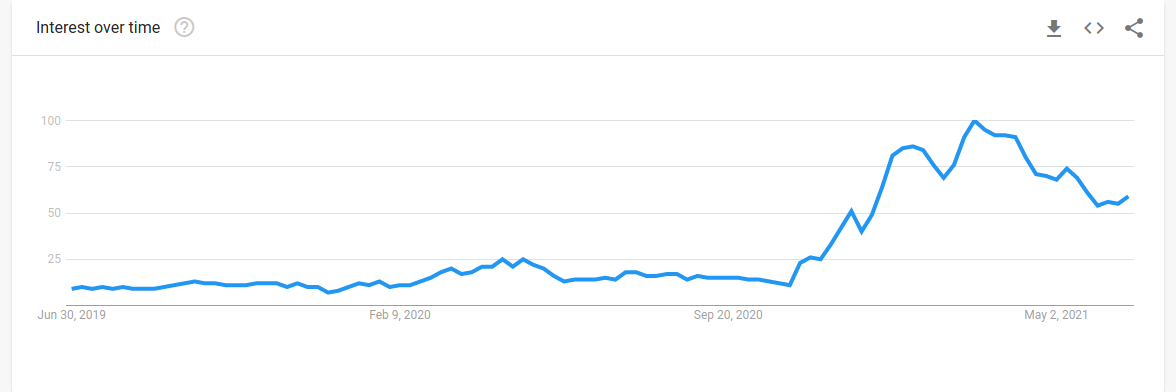

### **2.4. Czyszczenie danych za pomocą NLP**

In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy
import seaborn as sns

In [ ]:
#dodanie kolumny zawierającej zarówno tytuł jak i treść posta oraz stworzenie zmiennej typu string zawierającej wszystkie posty i komentarze
df['text'] = df.title.astype(str) + ' ' + df.body.astype(str)

df_old = df.loc[df['timestamp'] <= '2020-11-01 00:00:00'] #wpisy sprzed listopada 2020
df_new = df.loc[df['timestamp'] > '2020-11-01 00:00:00'] #wpisy od listopada 2020 do teraz

text_old = df_old['text'].to_list()
text_old = ' '.join(text_old).replace('Comment', '')
text_old = text_old.replace('https', '')

text_new = df_new['text'].to_list()
text_new = ' '.join(text_new).replace('Comment', '')
text_new = text_new.replace('https', '')

In [ ]:
#tokenizacja i lemmatyzacja tekstu
nlp = spacy.load("en_core_web_sm")
doc_old = nlp(text_old)
token_list_old = [token.lemma_ for token in doc_old if not token.is_stop]

doc_new = nlp(text_new)
token_list_new = [token.lemma_ for token in doc_new if not token.is_stop]

In [ ]:
print("Ilość słów - dane przed 2020.11:", len(token_list_old))
print("Ilość słów - dane po 2020.11:", len(token_list_new))

Ilość słów - dane przed 2020.11: 48837
Ilość słów - dane po 2020.11: 7340


W celu przygotowania danych do analizy sentymentu dokonałem tokenizacji i lemmatyzacji tekstu. Tokenizacja polega na podzieleniu ciągłego tekstu na pojedyncze słowa. Lemmatyzacja jest natomiast formą normalizacji tekstu i sprowadza się do próby doprowadzenia słowa do jego "podstawowej" formy. Dodatkowo czyszczę tekst z tak zwanych "stop words", czyli słów, które występują często, jednak nie wnoszą do treści tekstu żadnego znaczenia. Przykłady takich słów to "the", "or" lub "a".

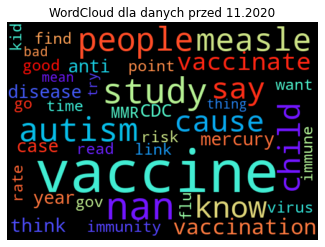

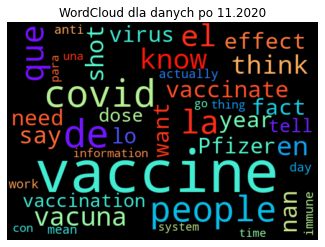

In [ ]:
stopwords = set(STOPWORDS)
stopwords = stopwords.update(["Comment", "https"])
textt = " ".join(word for word in token_list_old)
wordcloud = WordCloud(width = 500, height = 350, random_state=1, colormap='rainbow',
                      collocations=False, max_words=40, stopwords = STOPWORDS).generate(textt)

textt2 = " ".join(word for word in token_list_new)
wordcloud2 = WordCloud(width = 500, height = 350, random_state=1, colormap='rainbow',
                      collocations=False, max_words=40, stopwords = STOPWORDS).generate(textt2)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud dla danych przed 11.2020')
plt.show()
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('WordCloud dla danych po 11.2020')
plt.axis("off")
plt.show() #próbowałem ustawić wykresy obok siebie, ale funkcje subplot i imshow nie chciały współpracować

Mapy słów przedstawiają 40 najczęściej występujących w tytułach i treści postów oraz komentarzy dla obu zakresów czasu. Warto zwrócić uwagę na fakt, że lemmatyzacja nie poradziła sobie z mniej popularnymi słowami takimi jak "vaccination" czy "immunity" i pozostały one w tekście jako odrębne wyrazy.

Kolejnym ciekawym spostrzeżeniem są hiszpańskie słowa, które pojawiły się wśród najczęściej występujących wyrazów z okresu od listopada 2020. Można domniemywać, że nitka r/VaccineMyths wzbudziła zainteresowanie hiszpańskojęzycznych użytkowników Reddita. W analizie sentymentu nie będę ich brać pod uwagę, gdyż używana przeze mnie biblioteka nie jest do tego przystosowana.

Na drugim wykresie pojawiły się również hasła takie jak "covid" czy "Pfizer", co daje pewność, że podział został przeprowadzony poprawnie.

## **3. Model**

### 3.1. Analiza sentymentu

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
sa = SentimentIntensityAnalyzer()
df_old['scores'] = df_old['text'].apply(lambda text: sa.polarity_scores(text))
df_new['scores'] = df_new['text'].apply(lambda text: sa.polarity_scores(text))

In [ ]:
df_old['compound'] = df_old['scores'].apply(lambda score_dict: score_dict['compound'])
df_new['compound'] = df_new['scores'].apply(lambda score_dict: score_dict['compound'])

def compute_score(c):
    if c >= 0.1:
        return 'positive'
    elif c <= -0.1:
        return 'negative'
    else:
        return 'neutral'

df_old['sentiment'] = df_old['compound'].apply(lambda c :compute_score(c))
df_new['sentiment'] = df_new['compound'].apply(lambda c :compute_score(c))

Do analizy sentymentu wykorzystałem SentimentIntensityAnalyzer() z biblioteki nltk. Funkcja polarity_scores liczy "polarność" tekstu, a więc przypisuje każdemu z atrybutów positive, neutral i negative określoną wartość z zakresu 0 - 1. Następnie konkatenuje te wartości i przelicza je do zakresu od -1 do 1, gdzie -1 oznacza sentyment skrajnie negatywny, a 1 skrajnie pozytywny. Na podstawie tego wyniku przypisuję rekordowi grupę "positive", "neutral" lub "negative".

### 3.2. Wizualizacja wyników

In [ ]:
df_old[['text', 'scores', 'compound', 'sentiment']]

,text,scores,compound,sentiment
6,Comment Your OP. It's not a myth. Only one vac...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
7,Fuck you anti-vaxxing retards https://youtu.be...,"{'neg': 0.467, 'neu': 0.533, 'pos': 0.0, 'comp...",-0.5423,negative
8,Comment Because Anti-Vaxxers have no sense,"{'neg': 0.306, 'neu': 0.694, 'pos': 0.0, 'comp...",-0.2960,negative
9,"Comment What do you mean by ""your OP"". I am fa...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
10,"Comment When they say there's no thimerasol, t...","{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'comp...",-0.2960,negative
...,...,...,...,...
1533,Comment Same! I got vaccinated and now I'm suf...,"{'neg': 0.195, 'neu': 0.805, 'pos': 0.0, 'comp...",-0.5255,negative
1534,"Comment 100% agree with you, these people have...","{'neg': 0.088, 'neu': 0.692, 'pos': 0.22, 'com...",0.8126,positive
1535,Comment Anti-vax is [promulgated by Russian tr...,"{'neg': 0.072, 'neu': 0.764, 'pos': 0.163, 'co...",0.5267,positive
1536,Comment Don’t feel bad. I wasn’t in a coma & a...,"{'neg': 0.142, 'neu': 0.858, 'pos': 0.0, 'comp...",-0.7003,negative


In [ ]:
df_new[['text', 'scores', 'compound', 'sentiment']]

,text,scores,compound,sentiment
0,Health Canada approves AstraZeneca COVID-19 va...,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compou...",0.4019,positive
1,COVID-19 in Canada: 'Vaccination passports' a ...,"{'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'comp...",0.2500,positive
2,Coronavirus variants could fuel Canada's third...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,Canadian government to extend COVID-19 emergen...,"{'neg': 0.218, 'neu': 0.42, 'pos': 0.361, 'com...",0.1779,positive
4,Canada: Pfizer is 'extremely committed' to mee...,"{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'comp...",0.3384,positive
...,...,...,...,...
739,Comment I know people that are suing this stud...,"{'neg': 0.036, 'neu': 0.828, 'pos': 0.136, 'co...",0.7003,positive
740,"Comment The disclaimer at the end of the ""for ...","{'neg': 0.027, 'neu': 0.943, 'pos': 0.03, 'com...",0.0387,neutral
741,Comment That’s what I said. However there are ...,"{'neg': 0.124, 'neu': 0.822, 'pos': 0.054, 'co...",-0.4588,negative
742,"Comment It says:\n\n***Remarkably, zero of the...","{'neg': 0.108, 'neu': 0.892, 'pos': 0.0, 'comp...",-0.8917,negative


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


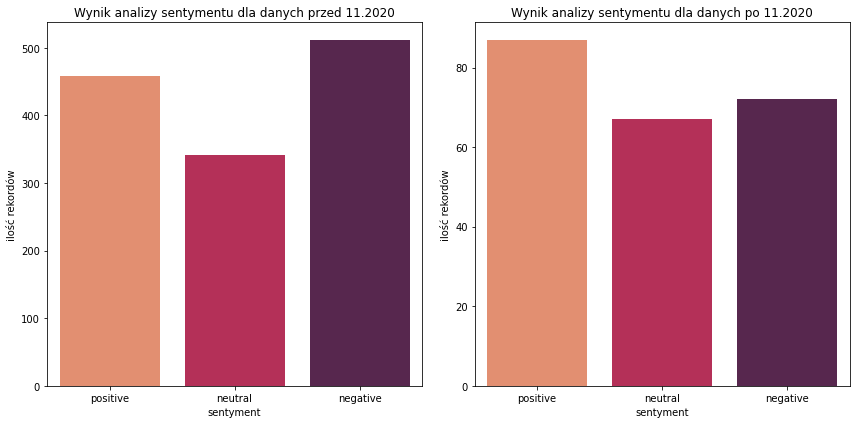

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(df_old['sentiment'], order=['positive', 'neutral', 'negative'], palette="rocket_r")
plt.title('Wynik analizy sentymentu dla danych przed 11.2020')
plt.xlabel('sentyment')
plt.ylabel('ilość rekordów')


plt.subplot(1, 2, 2)
sns.countplot(df_new['sentiment'], order=['positive', 'neutral', 'negative'], palette="rocket_r")
plt.title('Wynik analizy sentymentu dla danych po 11.2020')
plt.xlabel('sentyment')
plt.ylabel('ilość rekordów')

plt.tight_layout()
plt.show()

Powyższy wykres pokazuje proporcje prypisanych sentymentów. Warto nadmienić, iż w zbiorze zawierającym nowsze rekordy znajduje się znacznie mniej danych.

## **4. Wyniki, wnioski i podsumowanie**

W swojej pracy podjąłem próbę dokonania analizy sentymentu użytkowników Reddita na podstawie danych z nitki r/VaccineMyths. Zidentyfikowałem moment, w którym szczepienia przeciwko COVID-19 zyskały rozgłos medialny i w związku z nimi na nowo rozgorzała dyskusja wokół konsekwencji jakie niosą za sobą szczepienia.

Podzieliłem swoje dane na dwa zbiory: na pierwszy składały się posty dodane przed listopadem 2020 roku, w drugim znalazły się wszystkie nowsze rekordy.

Stworzone przeze mnie mapy słów pokazały pewne różnice między tymi zbiorami. Po wybuchu pandemii ze zbioru najczęściej prewijających się w postach słów zniknął chociażby "autyzm", za to pojawiły się "covid" czy "Pfizer".

Sama analiza sentymentu pokazała nieznaczny przechył w stronę pozytywną dla danych zebranych w ostatnich kilku miesiącach względem starszych wpisów. Trzeba jednak mieć na uwadze, iż część komentarzy zidentyfikowanych jako negatywne mogła być nakierowana w stronę przeciwników szczepień, a więc w kontekście sentymentu względem samych szczepień byłyby one pozytywne. Spora liczba rekordów została sklasyfikowana jako neutralne.

W przyszłości planuję rozwinąć ten projekt, spróbować dokładniej przefiltrować dane, wypróbować inne algorytmy służące do analizy sentymentu oraz dokonać ich ewaluacji.